# Evaluating tracrRNA bias from the Essential/non-essential tiling library

In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from core import setup_plots
import gpplot
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
import matplotlib as mpl
from core import add_transform_col
import sglearn
from lightgbm import LGBMRegressor
from scipy import stats
import shap
from core import summary_legacy
import numpy as np
import statsmodels.api as sm
from seqfold import dg
from tqdm import tqdm

In [2]:
setup_plots()
mpl.rcParams['figure.dpi']= 300

In [3]:
hsu_tracr = "GTTTTAGAGCTAGAAATAGCAAGTTAAAATAAGGCTAGTCCGTTATCAACTTGAAAAAGTGGCACCGAGTCGGTGC"
chen_tracr = "GTTTAAGAGCTATGCTGGAAACAGCATAGCAAGTTTAAATAAGGCTAGTCCGTTATCAACTTGAAAAAGTGGCACCGAGTCGGTGC"

In [4]:
lfc_in = pd.read_table('../data/external/Validation_Tiling_library_lfc_v5.txt')
eccite_human_reads = pd.read_csv('../data/external/human_sgrna_capture.csv')
eccite_mouse_reads = pd.read_csv('../data/external/mouse_sgrna_capture.csv')
eccite_sgrna_seqs = pd.read_csv('../data/external/eccite_sgrnas.csv')
seq_model_feature_importance = pd.read_csv('../data/processed/rs3_seq_shap_df.csv',
                                           names=['feature', 'importance'],
                                           skiprows=[0])


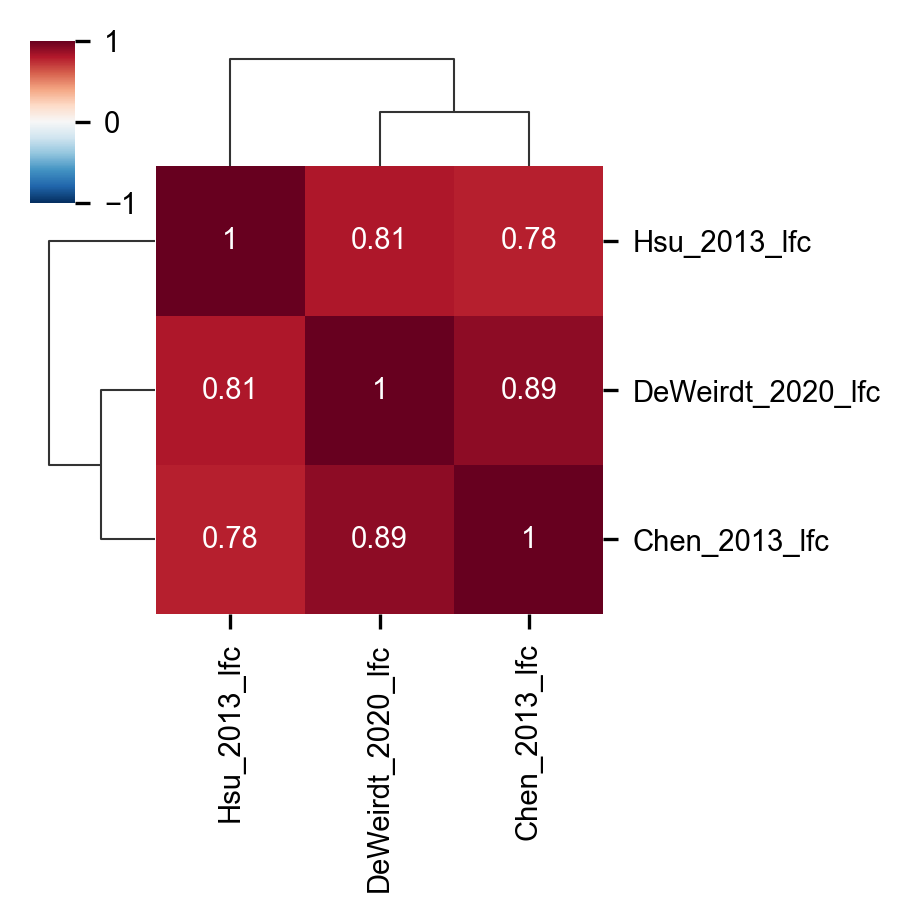

In [5]:
lfc_cols = ['DeWeirdt_2020_lfc', 'Hsu_2013_lfc', 'Chen_2013_lfc']
tracr_cor = lfc_in[lfc_cols].corr()
sns.clustermap(tracr_cor, cmap='RdBu_r', vmin=-1, vmax=1, annot=True, figsize=(3, 3))

In [6]:
long_lfcs = lfc_in.melt(value_vars=lfc_cols, id_vars=['Target Gene Symbol',
                                                      'Category',
                                                      'sgRNA Sequence',
                                                      'sgRNA Context Sequence',
                                                      'Rule Set 2 score'],
                        var_name='condition',
                        value_name='avg_lfc')
filtered_lfcs = (long_lfcs[long_lfcs['Category'] == 'Essential']
                 .reset_index(drop=True))
filtered_lfcs = add_transform_col(filtered_lfcs, 'avg_lfc',
                                         'yeo-johnson', 'scaled_avg_lfc',
                                         group_col=['Target Gene Symbol', 'condition'])
sg_avg_score = (filtered_lfcs.groupby(['sgRNA Sequence', 'sgRNA Context Sequence', 'Target Gene Symbol',
                                       'condition', 'Rule Set 2 score'])
                .agg({'scaled_avg_lfc': 'mean'})
                .reset_index())

Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. 

In [7]:
wide_scores = (sg_avg_score.pivot_table(index=['sgRNA Sequence', 'sgRNA Context Sequence', 'Target Gene Symbol'],
                                       values='scaled_avg_lfc',
                                       columns='condition')
               .reset_index())

In [8]:
wide_scores['hsu_chen'] = wide_scores['Hsu_2013_lfc'] - wide_scores['Chen_2013_lfc']
wide_scores['hsu_deweirdt'] = wide_scores['Hsu_2013_lfc'] - wide_scores['DeWeirdt_2020_lfc']

In [15]:
%%timeit
guide_sequence = wide_scores['sgRNA Sequence'].values[0]
dg((guide_sequence + hsu_tracr).replace('T', 'U'))

943 ms ± 95.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [19]:
%%timeit
guide_sequence = wide_scores['sgRNA Sequence'].values[0]
dg((guide_sequence).replace('T', 'U'))

1.47 ms ± 7.52 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [20]:
sampled_scores = wide_scores.sample(200, random_state=7)

In [23]:
dg_rr_results = []
for i, row in tqdm(sampled_scores.iterrows(), total= len(sampled_scores)):
    guide_sequence = row['sgRNA Sequence']
    hsu_dg = dg((guide_sequence + hsu_tracr).replace('T', 'U'))
    chen_dg = dg((guide_sequence + chen_tracr).replace('T', 'U'))
    dg_rr_results.append({'sgRNA Sequence': guide_sequence,
                          'Hsu folding energy': hsu_dg,
                          'Chen folding energy': chen_dg})


100%|██████████| 200/200 [08:24<00:00,  2.52s/it]


In [32]:
dg_rr_results_df = pd.DataFrame(dg_rr_results)
dg_rr_results_df['Change in folding energy'] = dg_rr_results_df['Hsu folding energy'] - dg_rr_results_df['Chen folding energy']
dg_rr_results_df = dg_rr_results_df.dropna()
dg_rr_results_df = dg_rr_results_df[dg_rr_results_df['Change in folding energy'].abs() != np.inf]
merged_samples = sampled_scores.merge(dg_rr_results_df)

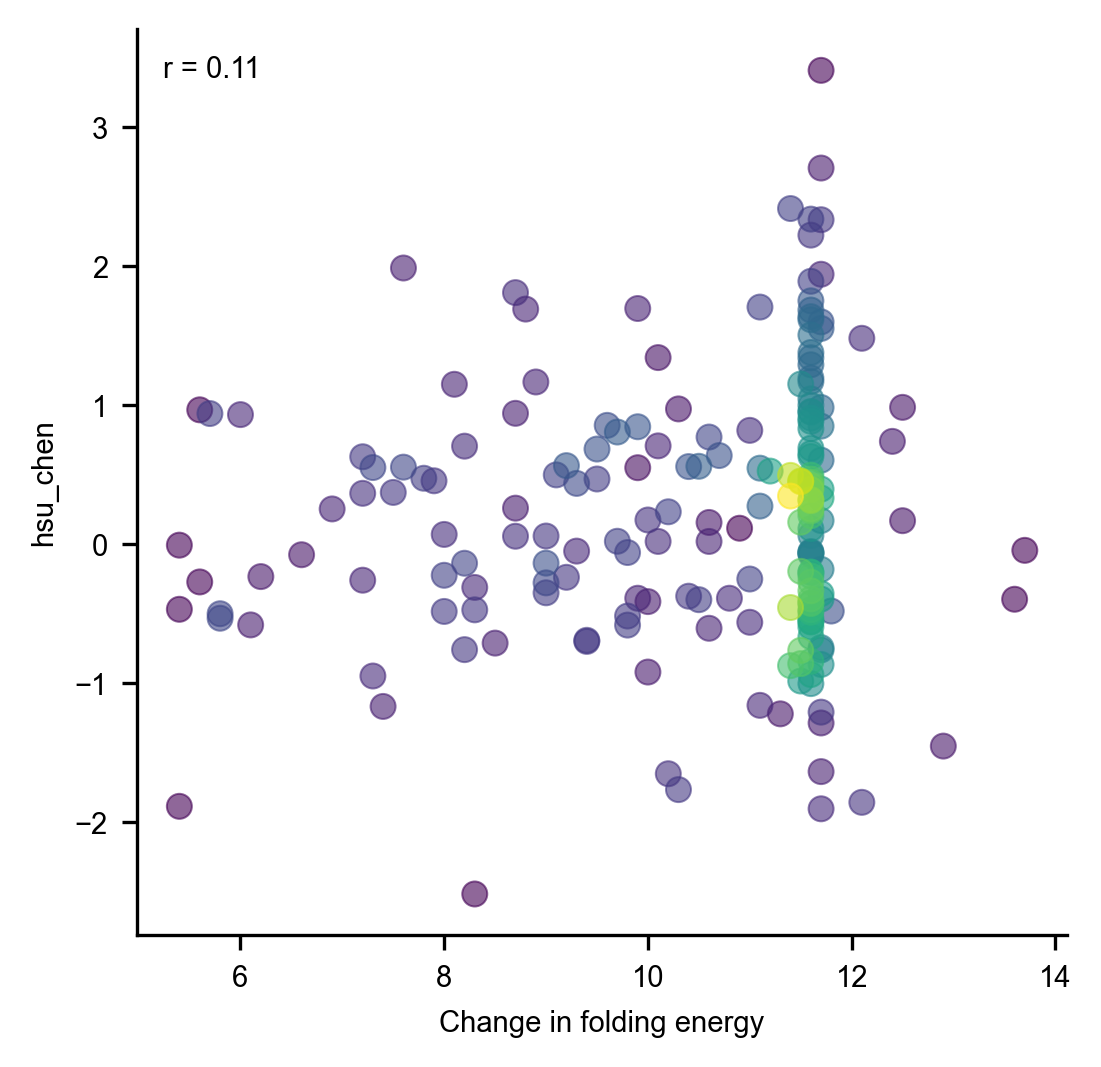

In [33]:
plt.subplots(figsize=(4,4))
gpplot.point_densityplot(data=merged_samples,
                         x='Change in folding energy',
                         y='hsu_chen')
gpplot.add_correlation(data=merged_samples,
                         x='Change in folding energy',
                         y='hsu_chen')
sns.despine()

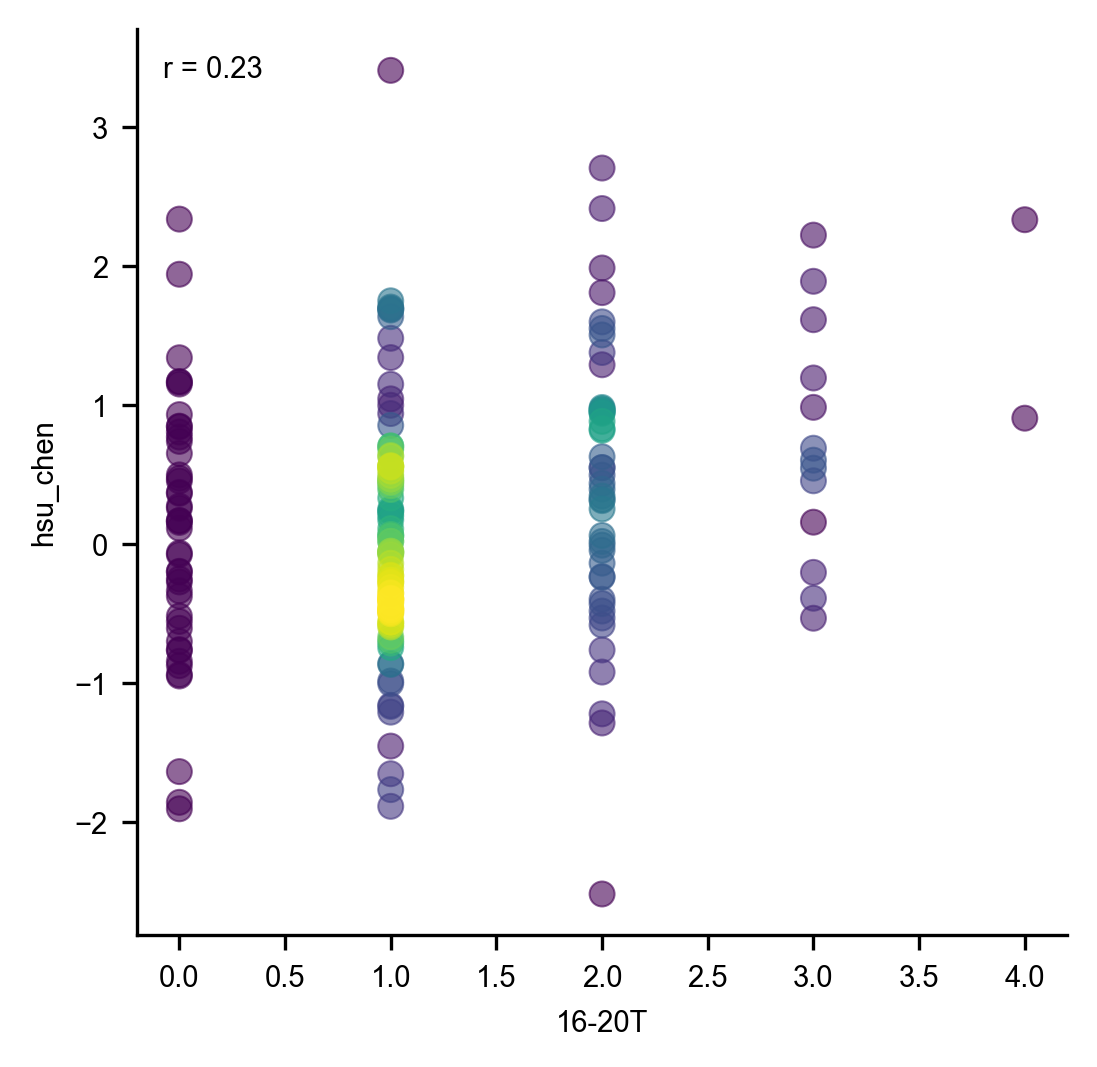

In [38]:
merged_samples['16-20T'] = merged_samples['sgRNA Sequence'].str[15:].str.count('T')
plt.subplots(figsize=(4,4))
gpplot.point_densityplot(data=merged_samples,
                         x='16-20T',
                         y='hsu_chen')
gpplot.add_correlation(data=merged_samples,
                         x='16-20T',
                         y='hsu_chen')
sns.despine()

In [9]:
def get_pearson_correlation(x, y):
    return stats.pearsonr(x, y)[0]

pearson_scorer = make_scorer(get_pearson_correlation)

X = sglearn.featurize_guides(wide_scores['sgRNA Context Sequence'])
y = wide_scores['hsu_chen']
cv_score = cross_val_score(LGBMRegressor(random_state=7), X, y, cv=5, n_jobs=5,
                           scoring=pearson_scorer)
print(cv_score)
print(cv_score.mean())

100%|██████████| 48730/48730 [02:11<00:00, 371.39it/s]


[0.45991954 0.48809177 0.47042456 0.43599019 0.44395914]
0.4596770425875917


In [10]:
model = LGBMRegressor(random_state=7, n_jobs=8)
model.fit(X, y)

LGBMRegressor(n_jobs=8, random_state=7)

In [11]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

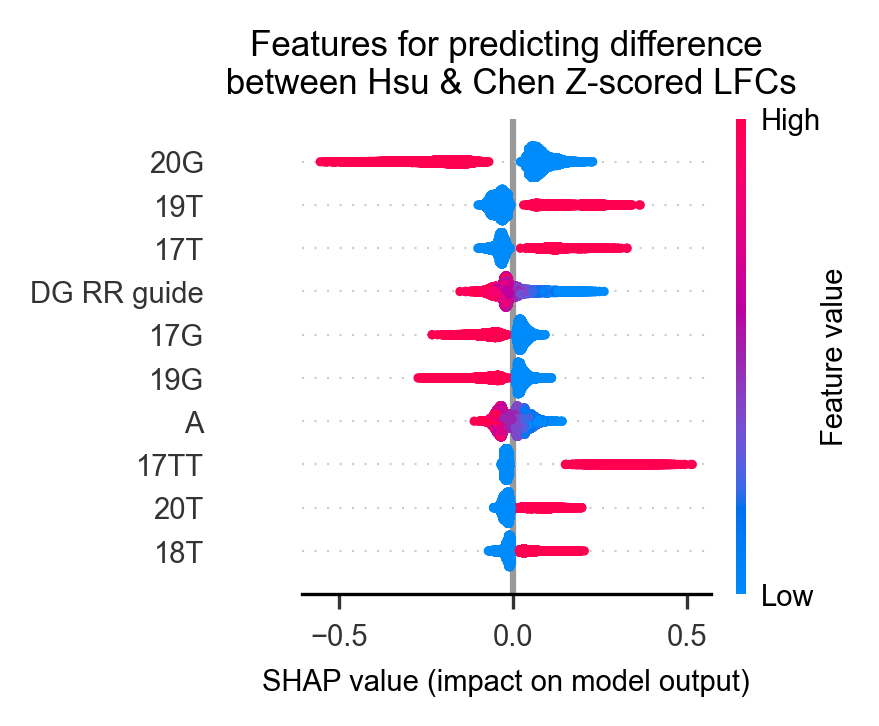

In [12]:
summary_legacy(shap_values, X, show=False, plot_size=(2.2, 2.1),
               point_size=5, text_size=None, color_bar_shrink=1,
               legend_aspect=30, max_display=10)
plt.xlabel('SHAP value (impact on model output)')
plt.title('Features for predicting difference\n between Hsu & Chen Z-scored LFCs')
gpplot.savefig('../figures/hsu_chen_dif_shap.pdf', dpi=300)

In [13]:
wide_scores['>16G'] = wide_scores['sgRNA Sequence'].str[-4:].str.contains('G')
wide_scores['>16T'] = wide_scores['sgRNA Sequence'].str[-4:].str.contains('T')
cat = []
for _, row in wide_scores.iterrows():
    if row['>16G'] & row['>16T']:
        cat.append('G & T')
    elif row['>16G'] & ~row['>16T']:
        cat.append('G & ~T')
    elif ~row['>16G'] & row['>16T']:
        cat.append('~G & T')
    else:
        cat.append('~G & ~T')
wide_scores['17-20 nt composition'] = pd.Categorical(cat,
                                                     categories=['~G & T',
                                                                 'G & T',
                                                                 '~G & ~T',
                                                                 'G & ~T'])

In [14]:

bin_counts = (wide_scores['17-20 nt composition'].value_counts()
              .reset_index())
bin_counts

,index,17-20 nt composition
0,G & T,19629
1,G & ~T,14635
2,~G & T,10952
3,~G & ~T,3514


In [15]:
bin_counts = (wide_scores['17-20 nt composition'].value_counts()
              .reset_index()
              .rename({'17-20 nt composition': 'count',
                       'index': '17-20 nt composition'}, axis=1))
wide_scores = (wide_scores.merge(bin_counts))
wide_scores['bin_name'] = pd.Categorical(wide_scores['17-20 nt composition'].astype(str) +
                                         '\nn=' + wide_scores['count'].astype(str),
                                         categories=['~G & T\nn=10952', 'G & T\nn=19629', '~G & ~T\nn=3514','G & ~T\nn=14635'])

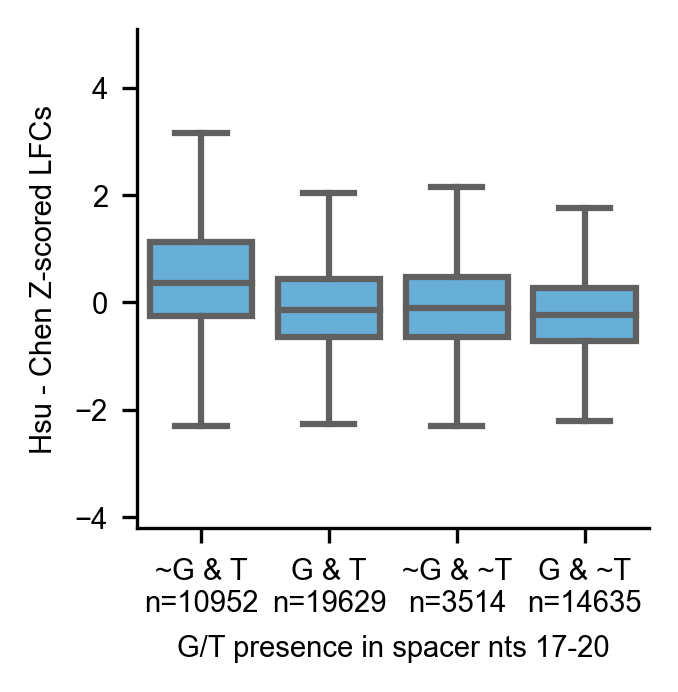

In [16]:
plt.subplots(figsize=(2.2, 2.2))
sns.boxplot(data=wide_scores, x='bin_name',
            y='hsu_chen', fliersize=0, color='#56b4e9')
sns.despine()
plt.ylabel('Hsu - Chen Z-scored LFCs')
plt.xlabel('G/T presence in spacer nts 17-20')
gpplot.savefig('../figures/hsu_chen_dif_g_t_bin.pdf')


In [17]:
(wide_scores.loc[wide_scores['17-20 nt composition'] == '~G & T',
                                'hsu_chen'].mean() -
 wide_scores.loc[wide_scores['17-20 nt composition'] == 'G & T',
                                'hsu_chen'].mean())

0.557897967165478

In [18]:
ttest1 = stats.ttest_ind(wide_scores.loc[wide_scores['17-20 nt composition'] == '~G & T',
                                'hsu_chen'],
                wide_scores.loc[wide_scores['17-20 nt composition'] == 'G & T',
                                'hsu_chen'])
ttest1[1]

0.0

In [19]:
stats.ttest_ind(wide_scores.loc[wide_scores['17-20 nt composition'] == '~G & ~T',
                                'hsu_chen'],
                wide_scores.loc[wide_scores['17-20 nt composition'] == 'G & ~T',
                                'hsu_chen'])

Ttest_indResult(statistic=10.904758435487214, pvalue=1.3322905604835591e-27)

In [20]:
(wide_scores.loc[wide_scores['17-20 nt composition'] == '~G & ~T',
                                'hsu_chen'].mean() -
 wide_scores.loc[wide_scores['17-20 nt composition'] == 'G & ~T',
                                'hsu_chen'].mean())

0.1649267954662298

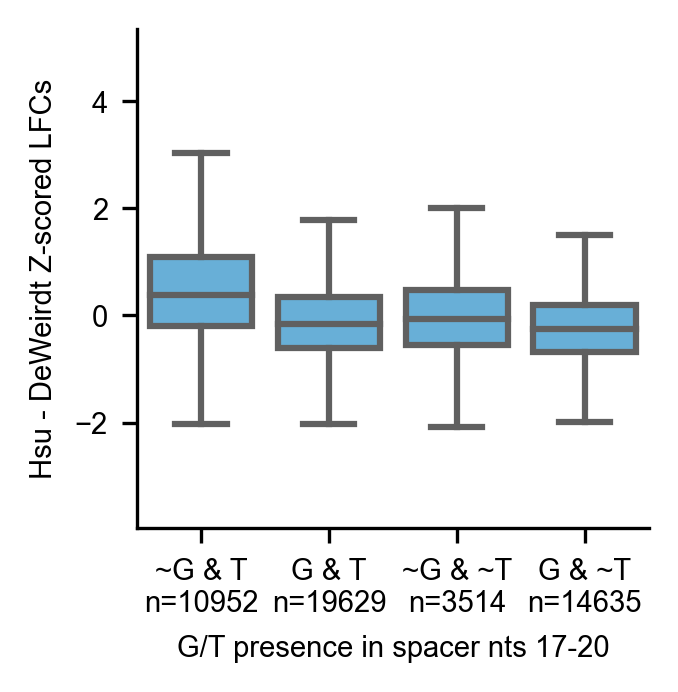

In [21]:
plt.subplots(figsize=(2.2, 2.2))
sns.boxplot(data=wide_scores, x='bin_name',
            y='hsu_deweirdt', fliersize=0, color='#56b4e9')
sns.despine()
plt.ylabel('Hsu - DeWeirdt Z-scored LFCs')
plt.xlabel('G/T presence in spacer nts 17-20')
gpplot.savefig('../figures/hsu_deweirdt_dif_g_t_bin.pdf')

In [22]:
def density_x_y(data, x, y, **kwargs):
    gpplot.point_densityplot(data, x, y,  **kwargs)
    gpplot.add_xy_line()


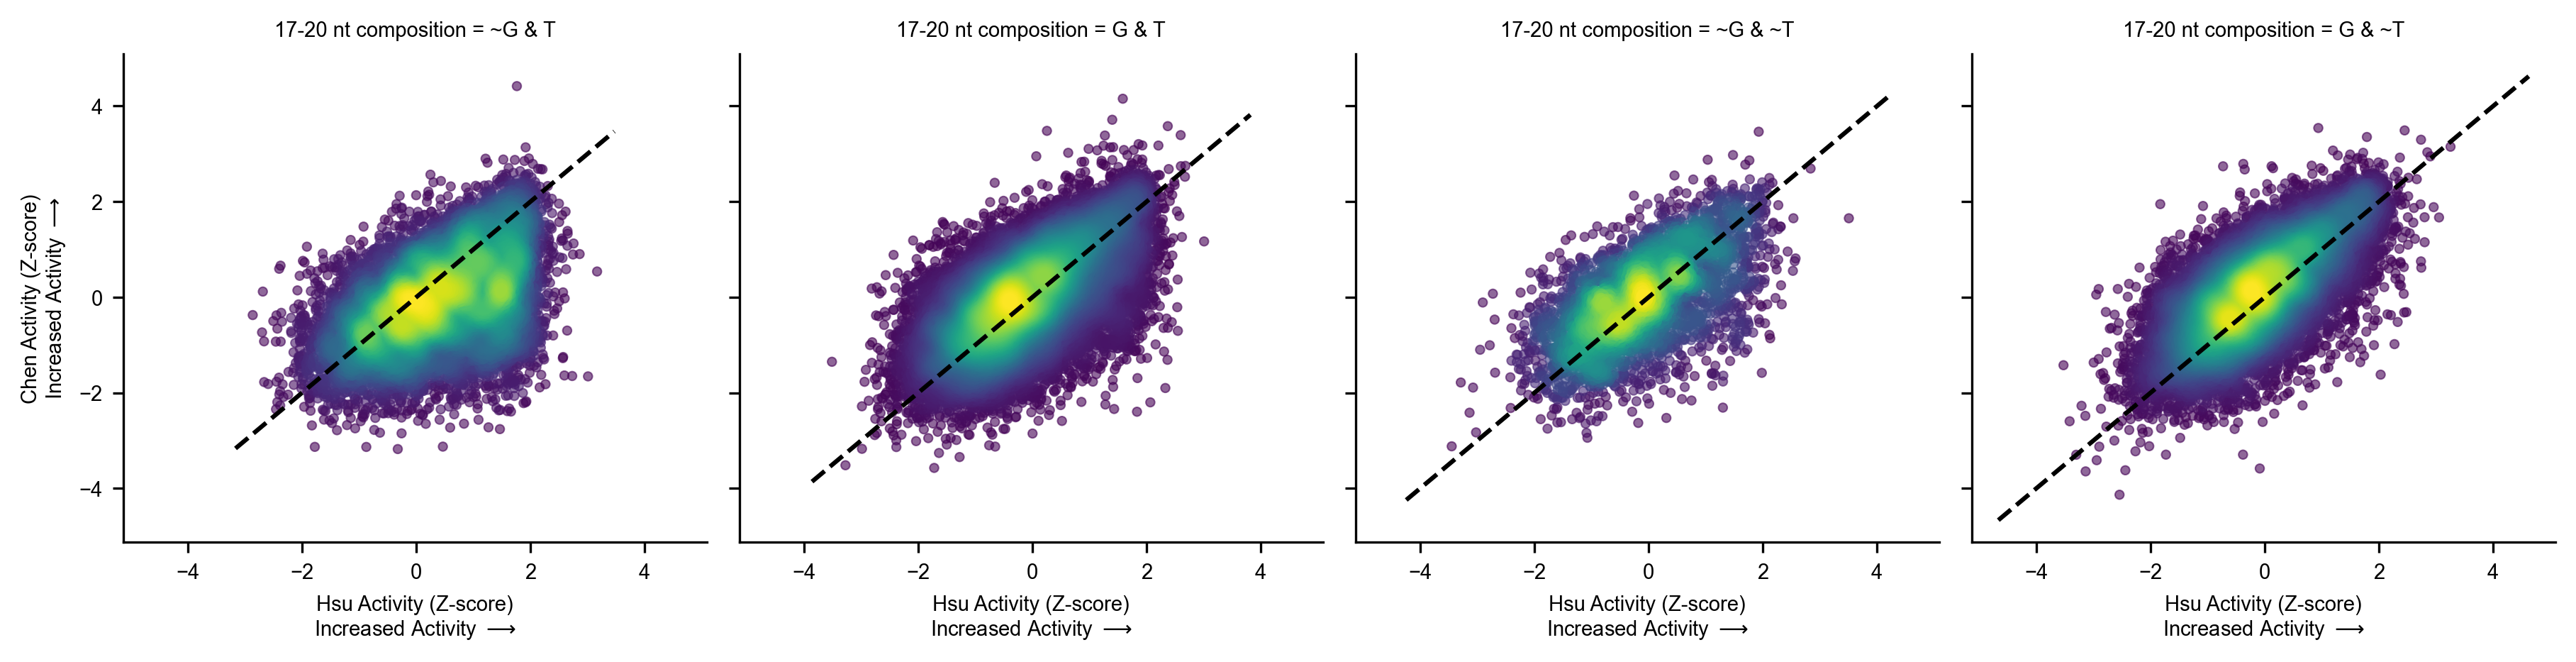

In [23]:
g = sns.FacetGrid(data=wide_scores, col='17-20 nt composition')
g.map_dataframe(density_x_y, x='Hsu_2013_lfc', y='Chen_2013_lfc', marker='.')
g.set_xlabels('Hsu Activity (Z-score)\n'
              'Increased Activity $\longrightarrow$')
g.set_ylabels('Chen Activity (Z-score)\n'
              'Increased Activity $\longrightarrow$')
gpplot.savefig('../figures/chen_hsu_scatter_g_t_bin.png', dpi=300)

In [24]:
wide_scores['chen_active'] = wide_scores['Chen_2013_lfc'] < 0
wide_scores['hsu_active'] = wide_scores['Hsu_2013_lfc'] < 0
wide_scores['chen_active_hsu_inactive'] = wide_scores['chen_active'] & ~wide_scores['hsu_active']
(wide_scores.groupby('17-20 nt composition')
 .apply(lambda df: df['chen_active_hsu_inactive'].sum()/len(df)))

17-20 nt composition
~G & T     0.262053
G & T      0.112741
~G & ~T    0.123791
G & ~T     0.084113
dtype: float64

In [25]:
wide_scores['>16G_count'] = wide_scores['sgRNA Sequence'].str[-4:].str.count('G')
wide_scores['>16T_count'] = wide_scores['sgRNA Sequence'].str[-4:].str.count('T')
t_counts = (wide_scores['>16T_count'].value_counts()
            .reset_index()
            .rename({'index': '>16T_count',
                    '>16T_count': 't_count'}, axis=1))
wide_scores = (wide_scores.merge(t_counts))
wide_scores['>16T_count_name'] = (wide_scores['>16T_count'].astype(str) + '\nn=' +
                                  wide_scores['t_count'].astype(str))

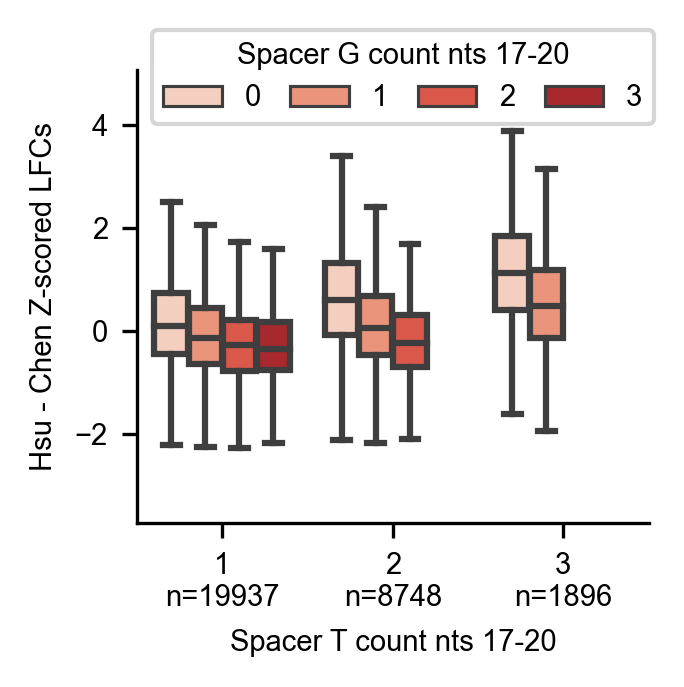

In [26]:
plt.subplots(figsize=(2.2,2))
sns.boxplot(data=wide_scores[wide_scores['>16T_count'] > 0],
            x='>16T_count_name', y='hsu_chen', hue='>16G_count',
                palette='Reds', fliersize=0)
plt.ylabel('Hsu - Chen Z-scored LFCs')
plt.xlabel('Spacer T count nts 17-20')
plt.legend(bbox_to_anchor=(0,1.12), loc="upper left", ncol=4,
           title='Spacer G count nts 17-20', columnspacing=1)
sns.despine()
gpplot.savefig('../figures/hsu_chen_g_t_count.pdf', dpi=300)

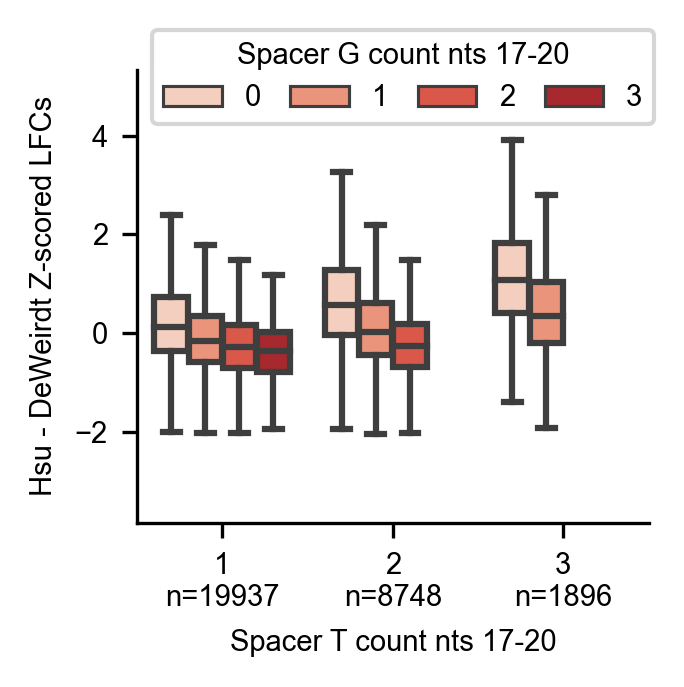

In [27]:
plt.subplots(figsize=(2.2,2))
sns.boxplot(data=wide_scores[wide_scores['>16T_count'] > 0], x='>16T_count_name',
            y='hsu_deweirdt', hue='>16G_count',
                palette='Reds', fliersize=0)
plt.ylabel('Hsu - DeWeirdt Z-scored LFCs')
plt.xlabel('Spacer T count nts 17-20')
plt.legend(bbox_to_anchor=(0,1.12), loc="upper left", ncol=4,
           title='Spacer G count nts 17-20', columnspacing=1)
sns.despine()
gpplot.savefig('../figures/hsu_deweirdt_g_t_count.pdf', dpi=300)

## Looking at ECCITE-Seq data

In [ ]:
eccite_data = (pd.concat([eccite_human_reads, eccite_mouse_reads])
                .pivot_table(index='sgRNA ID', values='Percent of Cells',
                             columns='method'))
eccite_data['LFC'] = np.log(eccite_data['sgRNA capture']/eccite_data['gDNA amplification'])
eccite_data = eccite_data.merge(eccite_sgrna_seqs, on='sgRNA ID')

In [29]:
eccite_data['>16G'] = eccite_data['sgRNA Sequence'].str[-4:].str.contains('G')
eccite_data['>16T'] = eccite_data['sgRNA Sequence'].str[-4:].str.contains('T')
ec_cat = []
for _, row in eccite_data.iterrows():
    if row['>16G'] & row['>16T']:
        ec_cat.append('G & T')
    elif row['>16G'] & ~row['>16T']:
        ec_cat.append('G & ~T')
    elif ~row['>16G'] & row['>16T']:
        ec_cat.append('~G & T')
    else:
        ec_cat.append('~G & ~T')
eccite_data['17-20 nt composition'] = pd.Categorical(ec_cat,
                                                     categories=['~G & T',
                                                                 'G & T',
                                                                 '~G & ~T',
                                                                 'G & ~T'])

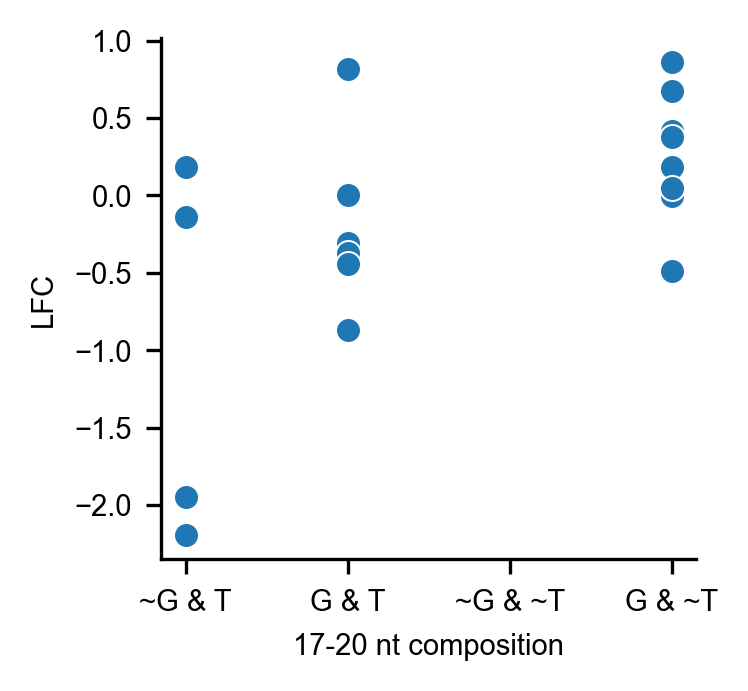

In [30]:
plt.subplots(figsize=(2.3, 2.3))
sns.scatterplot(data=eccite_data, x='17-20 nt composition', y='LFC')
sns.despine()

In [31]:
stats.ttest_ind(eccite_data.loc[eccite_data['17-20 nt composition'] == '~G & T',
                                'LFC'],
                eccite_data.loc[eccite_data['17-20 nt composition'] == 'G & T',
                                'LFC'])

Ttest_indResult(statistic=-1.6547335353657582, pvalue=0.13236429533143973)

In [32]:
eccite_data['>16G_count'] = eccite_data['sgRNA Sequence'].str[-4:].str.count('G')
eccite_data['>16T_count'] = eccite_data['sgRNA Sequence'].str[-4:].str.count('T')

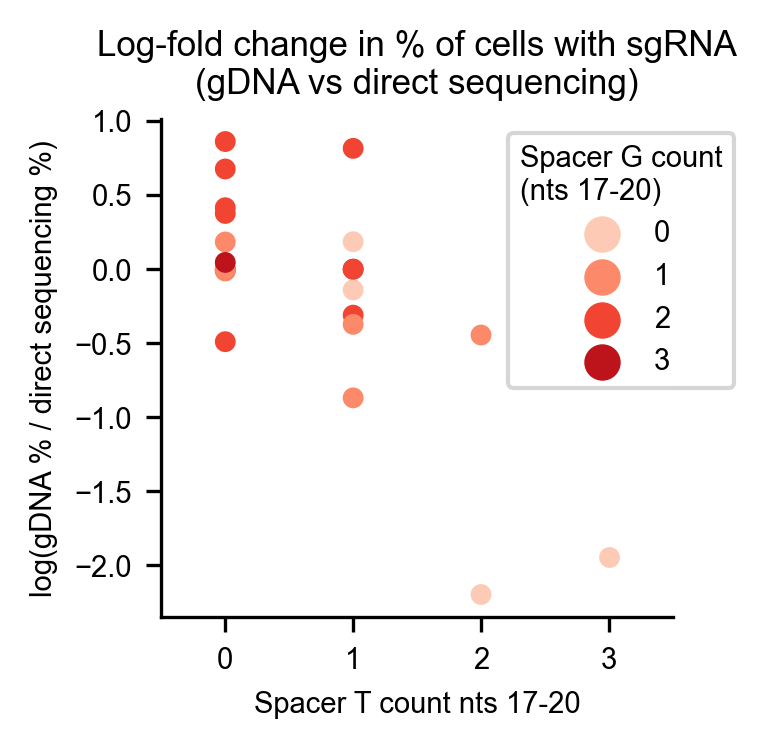

In [33]:
plt.subplots(figsize=(2.2,2.2))
sns.stripplot(data=eccite_data, x='>16T_count',
            y='LFC', hue='>16G_count',
                palette='Reds', jitter=False)
plt.xlabel('Spacer T count nts 17-20')
plt.ylabel("log(gDNA % / direct sequencing %)")
sns.despine()
plt.legend(bbox_to_anchor=(0.65,1), loc="upper left",
           title='Spacer G count\n(nts 17-20)')
plt.title('Log-fold change in % of cells with sgRNA\n(gDNA vs direct sequencing)')
gpplot.savefig('../figures/eccite_g_t_count.pdf', dpi=300)


In [34]:
eccite_data['const'] = 1
model = sm.OLS(eccite_data['LFC'],
               eccite_data[['>16T_count', '>16G_count', 'const']])
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                    LFC   R-squared:                       0.563
Model:                            OLS   Adj. R-squared:                  0.519
Method:                 Least Squares   F-statistic:                     12.87
Date:                Wed, 06 Apr 2022   Prob (F-statistic):           0.000256
Time:                        21:19:55   Log-Likelihood:                -15.507
No. Observations:                  23   AIC:                             37.01
Df Residuals:                      20   BIC:                             40.42
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
>16T_count    -0.5292      0.153     -3.463      0.0

## Data Output

In [38]:
eccite_data.drop('const', axis=1).to_csv('../data/processed/eccite_data.csv', index=False)
wide_scores.to_csv('../data/processed/chen_hsu_fig_data.csv', index=False)

## Feature importances vs Seq model

In [87]:
shap_df = pd.DataFrame(shap_values, columns=X.columns)
diff_model_importance = (shap_df.abs().mean()
                         .reset_index()
                         .rename({'index': 'feature',
                                  0: 'importance'}, axis=1))
seq_diff_feature_diff = (diff_model_importance
                         .merge(seq_model_feature_importance,
                                how='inner',
                                on='feature',
                                suffixes=['_tracr', '_seq']))
seq_diff_feature_diff['diff'] = seq_diff_feature_diff['importance_tracr'] - seq_diff_feature_diff['importance_seq']
seq_diff_feature_diff = seq_diff_feature_diff.sort_values('diff')
seq_diff_feature_diff.head(20)


,feature,importance_tracr,importance_seq,rank,diff
15,TT,0.005354,0.075182,0.996835,-0.069829
38,1C,0.007743,0.070915,0.992089,-0.063172
628,PolyT,0.012641,0.072012,0.993671,-0.059371
92,14G,0.015832,0.072113,0.995253,-0.056281
132,+1G,0.011192,0.066274,0.990506,-0.055081
622,Tm RD guide,0.009231,0.053459,0.987342,-0.044227
46,3C,0.001864,0.038356,0.979430,-0.036492
52,4G,0.000080,0.033227,0.977848,-0.033148
106,18C,0.024911,0.055270,0.988924,-0.030358
13,TA,0.000869,0.027537,0.971519,-0.026668


,feature,importance_tracr,importance_seq,rank,diff
0,GC content,0.009375,0.008738,0.886076,0.000637
1,A,0.034223,0.044790,0.984177,-0.010568
2,C,0.005716,0.004648,0.781646,0.001068
3,T,0.002078,0.006812,0.854430,-0.004734
4,G,0.001742,0.014920,0.941456,-0.013177
5,AA,0.000547,0.012745,0.925633,-0.012198
6,AC,0.004370,0.022238,0.962025,-0.017868
7,AT,0.000867,0.004109,0.753165,-0.003241
8,AG,0.009940,0.028418,0.974684,-0.018478
9,CA,0.000989,0.005564,0.821203,-0.004574


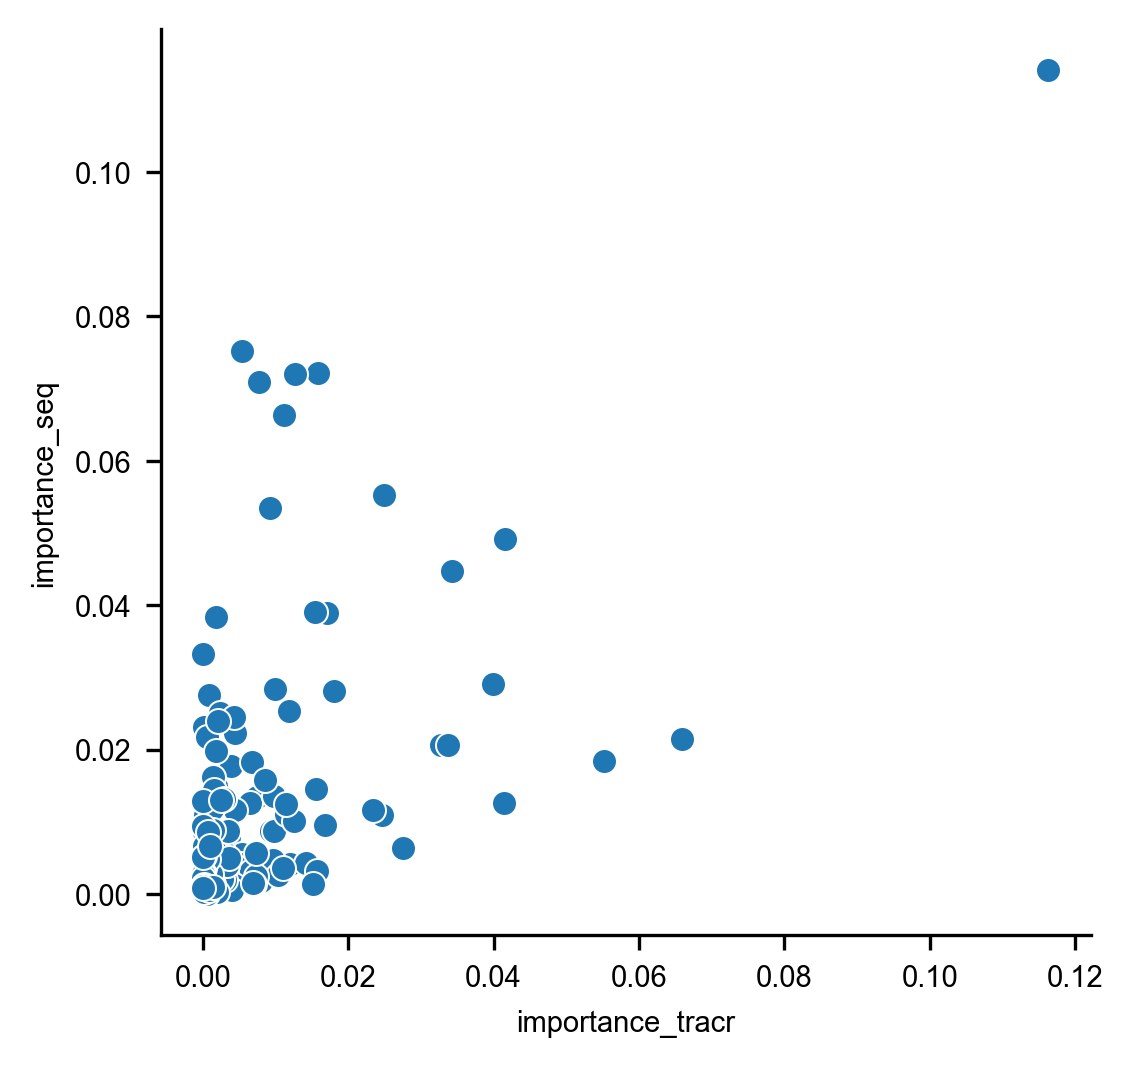

In [83]:
plt.subplots(figsize=(4,4))
sns.scatterplot(data=seq_diff_feature_diff, x='importance_tracr',
                y='importance_seq')
sns.despine()